## Question 3

In [2]:
#Imports
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.model_selection import GridSearchCV


In [3]:
SEED = 0

#Seeding RNG with seed = 0
rng = np.random.Generator(np.random.PCG64(seed=SEED))

### Part 2

In [4]:
data = io.loadmat('data.mat')
#print(data['description'])
samples = data['X']
labels = data['y']
test = data['X_test']

print("samples: ", samples.shape)
print("labels: ", labels.shape)


samples:  (5000, 12)
labels:  (5000, 1)


In [5]:
#Split
xTrainRaw, xTestRaw, yTrain, yTest = train_test_split(samples, labels, test_size=0.20, random_state=SEED, shuffle=True)

print("xTrain: ", xTrainRaw.shape)
print("xTest: ", xTestRaw.shape)
print("yTrain: ", yTrain.shape)
print("yTest: ", yTest.shape)

xTrain:  (4000, 12)
xTest:  (1000, 12)
yTrain:  (4000, 1)
yTest:  (1000, 1)


In [6]:
#Data editing
#Normalize data
xTrain = (xTrainRaw - xTrainRaw.mean()) / xTrainRaw.std()
xTest = (xTestRaw - xTrainRaw.mean()) / xTrainRaw.std()
test = (test - xTrainRaw.mean()) / xTrainRaw.std()

#Adding ficticious dim
ones = np.ones((xTrain.shape[0], 1))
xTrain = np.hstack((xTrain, ones))
print("xTrain with fict dim: ", xTrain.shape)

ones = np.ones((xTest.shape[0], 1))
xTest = np.hstack((xTest, ones))
print("xTest with fict dim: ", xTrain.shape)

ones = np.ones((test.shape[0], 1))
test = np.hstack((test, ones))
print("test data with fict dim: ", test.shape)

xTrain with fict dim:  (4000, 13)
xTest with fict dim:  (4000, 13)
test data with fict dim:  (1000, 13)


In [7]:
#Batch Gradient
def batchGrad(x, y, w, reg):
    result = y - expit(x.dot(w)) #logisticFn(x, w)
    result = -x.T.dot(result) + reg * w
    return result

#Take step
def update(w, step, grad):
    w = w - step * grad
    return w

def cost(x, y, w):
    result = y * np.log(expit(np.clip(x.dot(w), a_min = 0.0001,  a_max=1)))
    result = result + (1 - y) * np.log(1 - expit(np.clip(x.dot(w), a_min = 0.0001, a_max=1 )))
    result = np.sum(result)
    return -result

In [9]:

def train(tolerance, max_iter, gradFn, trainSize, step, reg):
    #Start guess at 0
    w = np.zeros((1, xTrain.shape[1])).T

    #Find first gradient
    iter = 0
    
    while iter < max_iter:
        grad = gradFn(xTrain[:trainSize], yTrain[:trainSize], w, reg)
        w = update(w, step, grad)
        iter += 1
        if np.all(abs(grad)) < tolerance:
            print("Met Tolarence")
            break
    return w

In [ ]:
iter = [400, 600, 1000, 1500, 3000, 5000]
stepSize = [0.001, 0.001, 0.0001]
reg = [0.01, 0.1, 1, 10, 100]
batchCostsForStep = []
# param_grid = [
#   {'reg': [0.001, 0.01, 0.1, 1, 10], 'stepSize' : [0.001, 0.001, 0.0001]},
#   {'iter': [100, 200, 400, 600, 1000, 1500, 3000, 5000]},
#  ]
for step in stepSize:
    costDict = {}
    for r in reg:
        currCost = []
        for i in iter:
            w = train(0.1, i, batchGrad, 4000, step, r)
            c = cost(xTrain[:4000], yTrain[:4000], w)
            currCost.append(c)
        costDict[f'Reg: = {r}'] = currCost
    batchCostsForStep.append(costDict)

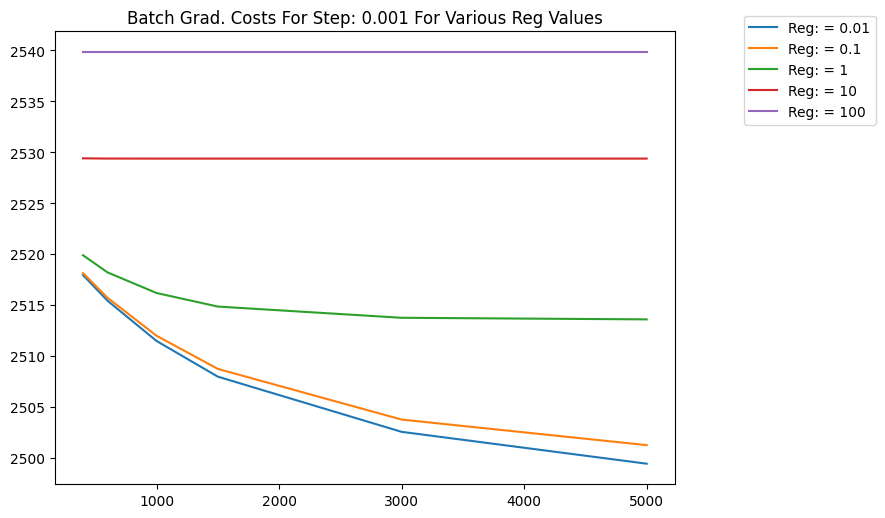

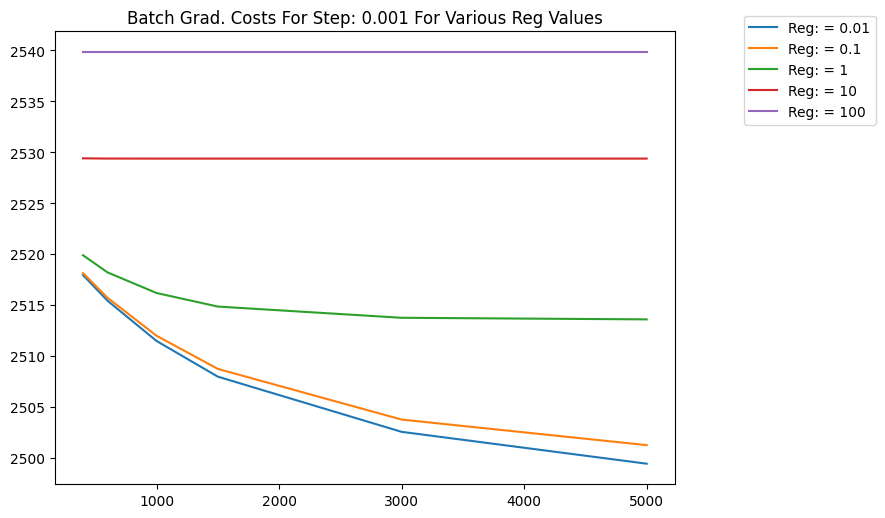

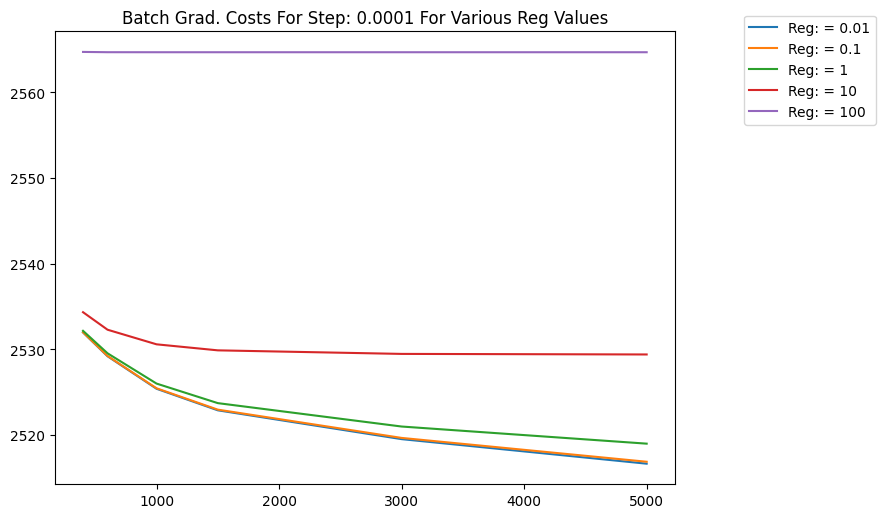

In [277]:
for i in range(0, len(stepSize)):
    plt.figure(figsize=(8, 20))
    for key in batchCostsForStep[i].keys():
        plt.subplot(3, 1, i+1)
        plt.plot(iter, batchCostsForStep[i][key], label = key)
        plt.title(f"Batch Grad. Costs For Step: {stepSize[i]} For Various Reg Values")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

### Section 4

In [347]:
#Stochastic Gradient
def stoGrad(x, y, w, reg):
    randIdx = rng.integers(0, x.shape[0])

    xi = x[randIdx]
    yi = y[randIdx]

    result = yi - expit(xi.dot(w)) #logisticFn(x, w)
    result = np.reshape((result * xi), (13,1))
    # print((reg*w).shape)
    # print(result.shape)
    result = -result + reg * w
    return result

In [351]:
#w = train(0.1, 20, stoGrad, 4000, 0.0001, 0)

iter = [400, 600, 1000, 1500, 3000, 5000, 10000]
stepSize = [0.05, 0.01, 0.005, 0.001]
reg = [0.001, 0.01, 0.1, 0]
stoCostsForStep = []
for step in stepSize:
    costDict = {}
    for r in reg:
        currCost = []
        for i in iter:
            w = train(0.01, i, stoGrad, 4000, step, r)
            c = cost(xTrain[:4000], yTrain[:4000], w)
            currCost.append(c)
        costDict[f'Reg: = {r}'] = currCost
    stoCostsForStep.append(costDict)

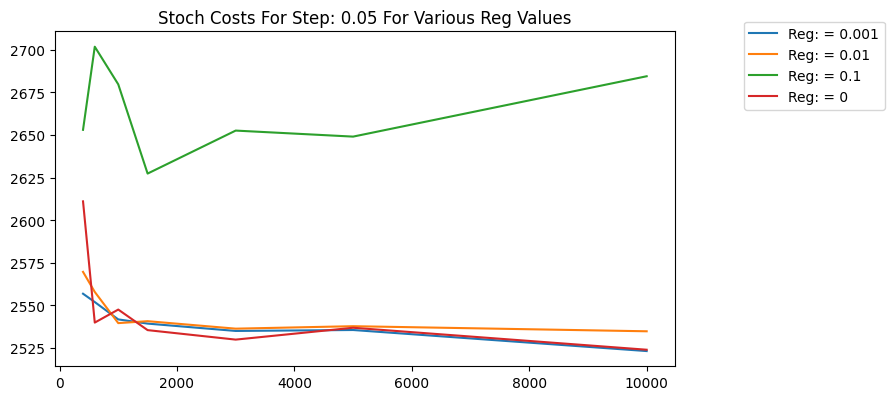

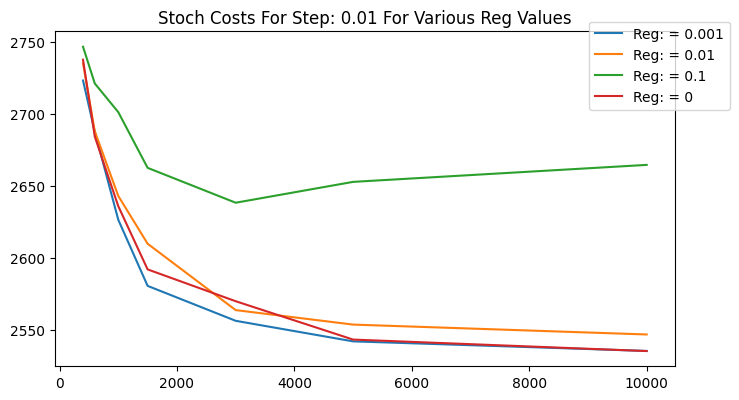

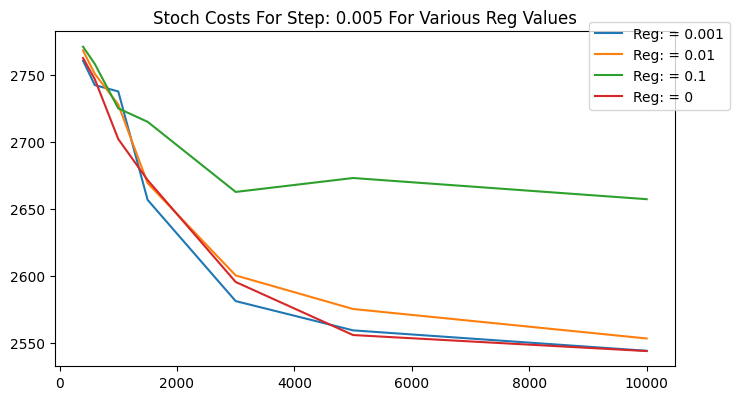

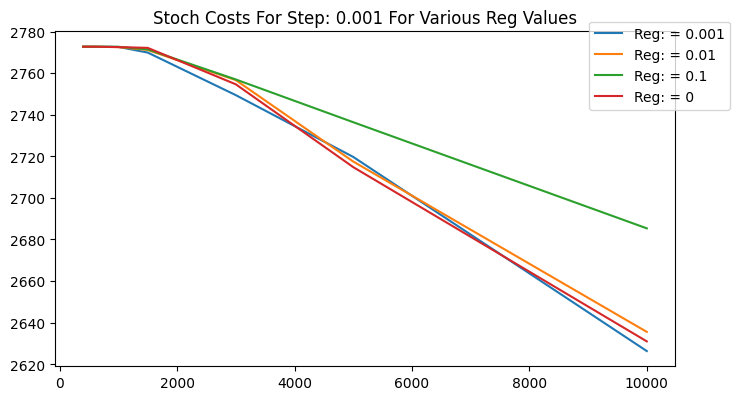

In [353]:
for i in range(0, len(stepSize)):
    plt.figure(figsize=(8, 20))
    for key in stoCostsForStep[i].keys():
        plt.subplot(len(stepSize), 1, i+1)
        plt.plot(iter, stoCostsForStep[i][key], label = key)
        plt.title(f"Stoch Costs For Step: {stepSize[i]} For Various Reg Values")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [10]:
w = train(0.1, 10000, batchGrad, 4000, 0.001, 0.01)
print(w)

[[ 24.65162987]
 [ 11.75244172]
 [ -7.50697727]
 [ -5.43837378]
 [ -0.89329382]
 [  1.51014325]
 [ -2.3797864 ]
 [ -2.7562696 ]
 [  7.01234347]
 [  7.02813575]
 [-21.33286301]
 [ -4.32544368]
 [  7.84435412]]


In [11]:
print(xTest[0])

[-0.21745224 -0.39772002 -0.39744183 -0.38714876 -0.40587101  0.0106644
  1.42943861 -0.379084   -0.32010472 -0.39799821 -0.07835673 -0.38993067
  1.        ]


In [12]:
validationY = np.round(expit(xTest.dot(w)))
validationY = np.reshape(validationY, (validationY.shape[0]))
print(yTest.shape)
yTest = np.reshape(yTest, (yTest.shape[0]))
# print(validationY.reshape(1, validationY.shape[0]))
# print(yTest.reshape(1, validationY.shape[0]))
correct = 0
total = len(validationY)
for i in range(0, len(yTest)):
    if validationY[i] == yTest[i]:
        correct += 1
print(correct/total)

(1000, 1)
0.947


In [14]:
result = np.round(expit(test.dot(w)))
print(result.shape)
result = np.reshape(result, (result.shape[0]))
import pandas as pd
list = [*range(1, len(result)+1)]
outputDict = {"Id":list, "Category": result}
df = pd.DataFrame(outputDict)
df.to_csv('wineResult.csv', index=False)

(1000, 1)


### Section 5